346/346 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step


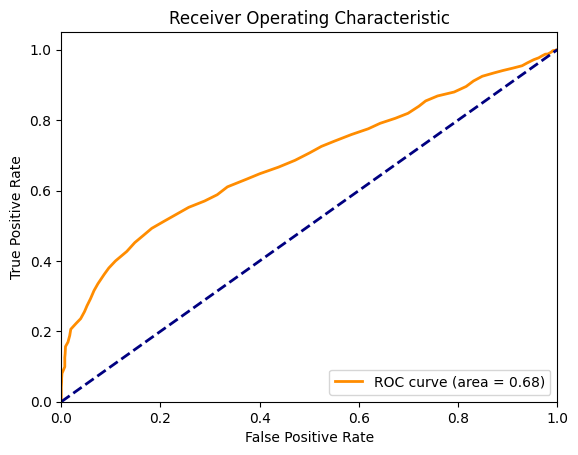

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1409
           1       0.61      0.65      0.63      1340

    accuracy                           0.62      2749
   macro avg       0.62      0.62      0.62      2749
weighted avg       0.62      0.62      0.62      2749



In [2]:
import numpy as np
import scipy.io as sio
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM
from sklearn.decomposition import PCA

# Load the data
file_path = 'C:\\Users\\UC\\Documents\\NeuMa\\22117124\\new.mat'
new = sio.loadmat(file_path)
Label = new['label_list'].flatten()
EEG = new['EEG']

# Feature extraction for DL using CNN and LSTM
input_shape = (EEG.shape[0], EEG.shape[1], 1)

input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)

# Reshape for LSTM layer
reshape_layer = Reshape((flatten.shape[1], 1))(flatten)
lstm_layer = LSTM(64)(reshape_layer)
dense1 = Dense(128, activation='relu')(lstm_layer)
output_layer = Dense(64, activation='relu')(dense1)  # Output for feature extraction

cnn_rnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_rnn_model.compile(optimizer='adam', loss='mse')

# Reshape data for CNN input
data_cnn = EEG.reshape(EEG.shape[2], EEG.shape[0], EEG.shape[1], 1)

cnn_rnn_features = cnn_rnn_model.predict(data_cnn)

# Handle imbalanced data using SMOTE
smote = SMOTE()
dl_features_resampled, labels_resampled = smote.fit_resample(cnn_rnn_features, Label)
pca = PCA(n_components=10)  # You can adjust the number of components as needed
dl_features_pca = pca.fit_transform(dl_features_resampled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dl_features_pca, labels_resampled, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100)  # You can adjust parameters as needed
rf_clf.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Predict labels on the test set
y_pred = rf_clf.predict(X_test)

# Print classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))
